In [1]:
using Revise, Plots, FFTW, LinearAlgebra, LaTeXStrings, Random, Distributions

In [2]:
includet("../src/SparseSpikes.jl")
using .SparseSpikes

Define ground truth amplitudes and positions

In [3]:
domain = [0, 1]

x0 = [0.1, 0.5, 0.9]
a0 = [1.5, 0.8, -1.0]

μ0 = DiscreteMeasure(x0, a0)

DiscreteMeasure([0.1, 0.5, 0.9], [1.5, 0.8, -1.0], 1, 3)

In [4]:
# Define the number of Fourier coefficients
fc = 6
n = 2fc + 1

# Define noise level
noise_level = 0.1

# Seed for noise
# Random.seed!(22)

0.1

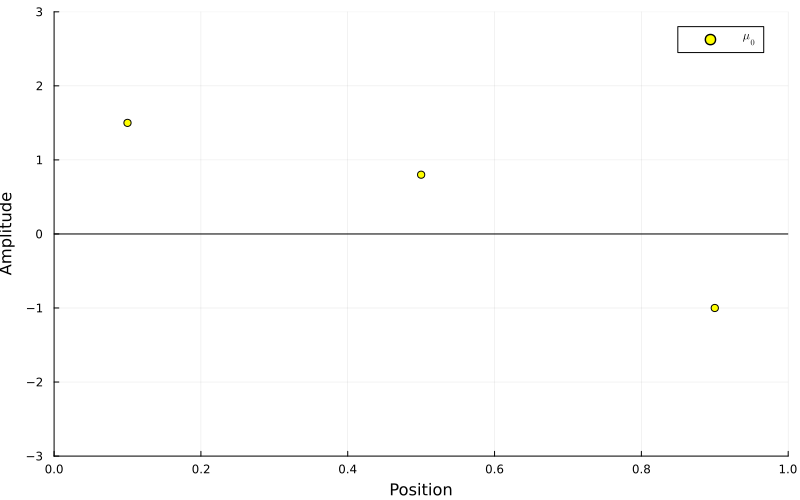

In [5]:
# Define the plot
num_points = 1000
plt_grid = range(domain..., length=(num_points + 1))
plot_size = (400, 250) .* 2
plt = plot(xlims=extrema(domain), ylims=(-3, 3), xlabel="Position", ylabel="Amplitude", legend=:topright, size=plot_size)
hline!(plt, [0], linestyle=:solid, color=:black, label="")

plot_spikes!(plt, μ0, label=L"μ_0", color=:yellow)

In [6]:
ops = fourier_operators_1D(fc, plt_grid)

Operators(var"#ϕ#12"{Int64}(6), var"#Φ#13"{var"#ϕ#12"{Int64}}(var"#ϕ#12"{Int64}(6)), var"#adjΦ#14"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, var"#adjΦ#11#15"{var"#ϕ#12"{Int64}}}(0.0:0.001:1.0, var"#adjΦ#11#15"{var"#ϕ#12"{Int64}}(var"#ϕ#12"{Int64}(6))))

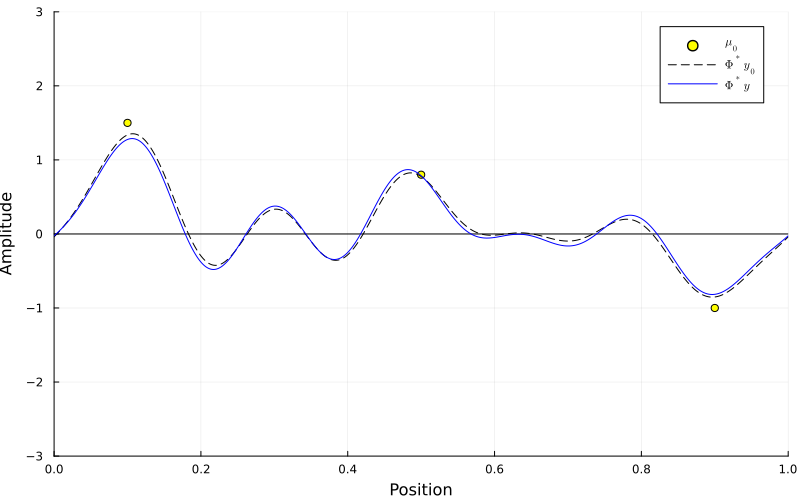

In [7]:
# Calculate the observation y0 = Φμ0
y0 = ops.Φ(x0, a0)

# Add noise to the observation y = y0 + w
sigma = noise_level * norm(y0)
w = fftshift(fft(randn(length(y0))))
w = w / norm(w) * sigma
y = y0 + w

plt_obs = deepcopy(plt)

plot!(plt_obs, plt_grid, ops.adjΦ(y0), label=L"Φ^*y_0", color=:black, linestyle=:dash)
plot!(plt_obs, plt_grid, ops.adjΦ(y), label=L"Φ^*y", color=:blue)

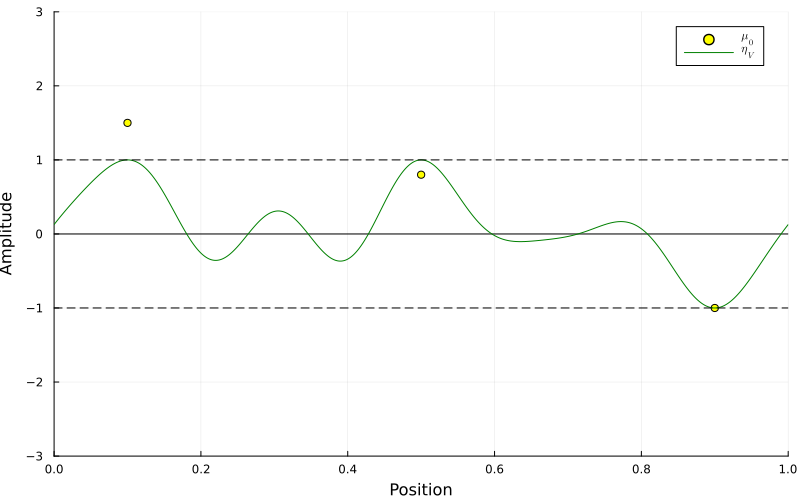

In [8]:
ηV = pre_certificate(μ0, ops)

plt_cert = deepcopy(plt)

plot!(plt_cert, plt_grid, ηV, label=L"η_V", color=:green)
hline!(plt_cert, [1, -1], linestyle=:dash, color=:black, label="")

## SDP

In [15]:
λ = 0.01

prob = BLASSO(y, ops, domain, λ)

prob_sdp = deepcopy(prob)

@time solve!(prob_sdp, :SDP)

Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 262             
  Affine conic cons.     : 1 (28 rows)
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 27              
  Matrix variables       : 1 (scalarized: 406)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - dual attempts          : 0             

BLASSO{ComplexF64}(ComplexF64[0.10624099980865864 - 0.45653532774094485im, -0.35231880325377596 + 0.03461920140119847im, 0.1251489428009446 + 0.41552726926369854im, -0.26435030212990773 + 0.6580868121346403im, 0.280591616716141 + 0.5477084699213827im, -0.11458600784282336 + 0.3836003724322327im, 0.34805773042130306 + 0.0im, -0.11458600784282336 - 0.3836003724322327im, 0.280591616716141 - 0.5477084699213827im, -0.26435030212990773 - 0.6580868121346403im, 0.1251489428009446 - 0.41552726926369854im, -0.35231880325377596 - 0.03461920140119747im, 0.10624099980865864 + 0.45653532774094485im], Operators(var"#ϕ#12"{Int64}(6), var"#Φ#13"{var"#ϕ#12"{Int64}}(var"#ϕ#12"{Int64}(6)), var"#adjΦ#14"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, var"#adjΦ#11#15"{var"#ϕ#12"{Int64}}}(0.0:0.001:1.0, var"#adjΦ#11#15"{var"#ϕ#12"{Int64}}(var"#ϕ#12"{Int64}(6)))), [0, 1], 0.01, DiscreteMeasure([0.09852148934089408, 0.49366819570598297, 0.9003194257872149], [1.4064740

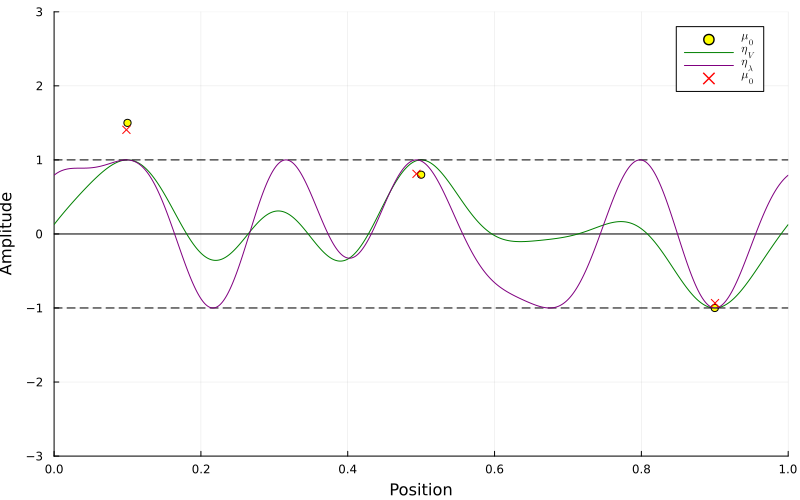

In [14]:
plt_sdp = deepcopy(plt_cert)

# dual polynomial
ηλ = ops.adjΦ(prob_sdp.p) * sqrt(n)
plot!(plt_sdp, plt_grid, ηλ, label=L"η_λ", color=:purple)
plot_spikes!(plt_sdp, prob_sdp.μ, label=L"μ_0", color=:red, marker=:x)

## Sliding Frank-Wolfe

In [34]:
prob_sfw = deepcopy(prob)
prob_sfw.λ = 0.01

solve!(prob_sfw, :SFW)

BLASSO{ComplexF64}(ComplexF64[0.10624099980865864 - 0.45653532774094485im, -0.35231880325377596 + 0.03461920140119847im, 0.1251489428009446 + 0.41552726926369854im, -0.26435030212990773 + 0.6580868121346403im, 0.280591616716141 + 0.5477084699213827im, -0.11458600784282336 + 0.3836003724322327im, 0.34805773042130306 + 0.0im, -0.11458600784282336 - 0.3836003724322327im, 0.280591616716141 - 0.5477084699213827im, -0.26435030212990773 - 0.6580868121346403im, 0.1251489428009446 - 0.41552726926369854im, -0.35231880325377596 - 0.03461920140119747im, 0.10624099980865864 + 0.45653532774094485im], Operators(var"#ϕ#12"{Int64}(6), var"#Φ#13"{var"#ϕ#12"{Int64}}(var"#ϕ#12"{Int64}(6)), var"#adjΦ#14"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, var"#adjΦ#11#15"{var"#ϕ#12"{Int64}}}(0.0:0.001:1.0, var"#adjΦ#11#15"{var"#ϕ#12"{Int64}}(var"#ϕ#12"{Int64}(6)))), [0, 1], 0.01, DiscreteMeasure([0.09872877872680048, 0.9004656564302528, 0.49372432322914145, 0.213867323

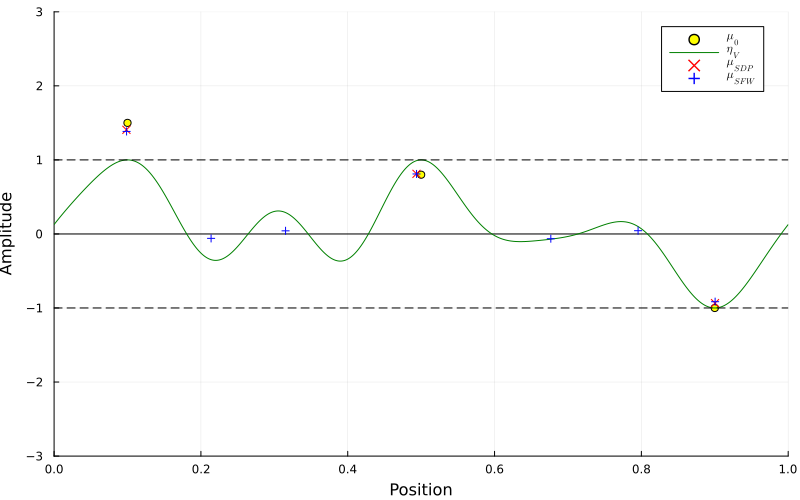

In [32]:
plt_sfw = deepcopy(plt_cert)

plot_spikes!(plt_sfw, prob_sdp.μ, label=L"μ_{SDP}", color=:red, marker=:x)
plot_spikes!(plt_sfw, prob_sfw.μ, label=L"μ_{SFW}", color=:blue, marker=:cross)
